# Monte Carlo Portfolio Optimization

This notebook handles data acquisition, loading, and comprehensive analysis for portfolio optimization using Monte Carlo simulations.

## 1. Setup and Configurations

In [58]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create data directory if it doesn't exist
os.makedirs("../data", exist_ok=True)

## 2. Data Acquisition

Fetching adjusted close prices for selected assets.

In [59]:
tickers = ["AAPL", "MSFT", "GOOGL", "SPY"]

print("Downloading data...")
data = yf.download(
    tickers,
    start="2020-01-01",
    end="2025-12-31",
    auto_adjust=True,
    progress=False
)

# Handle Multi-Index columns
if isinstance(data.columns, pd.MultiIndex):
    data = data["Close"]

data_to_save = data.reset_index()
output_path = "../data/asset_prices.csv"
data_to_save.to_csv(output_path, index=False)

print(f"✅ Saved: {output_path}")
data.head()

✅ Saved: ../data/asset_prices.csv


Ticker,AAPL,GOOGL,MSFT,SPY
Date,,,,
2020-01-02,72.400513,67.920815,152.505707,297.698883
2020-01-03,71.696632,67.565475,150.606735,295.444733
2020-01-06,72.267937,69.366386,150.995987,296.571838
2020-01-07,71.928040,69.232399,149.619293,295.737915
2020-01-08,73.085121,69.725174,152.002441,297.314117


## 3. Data Loading & Preprocessing

In [60]:
def load_processed_data(file_path):
    df = pd.read_csv(file_path)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    return df

prices = load_processed_data("../data/asset_prices.csv")
print("Data loaded successfully.")

Data loaded successfully.


# 4 . Statistical Estimation


In [61]:
# ============================================================
# 4. Statistical Estimation of Returns (PHASE 1)
# ============================================================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ----- 1️⃣ Compute Log Returns -----
returns = np.log(prices / prices.shift(1)).dropna()

print("Returns computed successfully.")
returns.head()


Returns computed successfully.


,AAPL,GOOGL,MSFT,SPY
Date,,,,
2020-01-03,-0.009770,-0.005245,-0.012530,-0.007601
2020-01-06,0.007937,0.026305,0.002581,0.003808
2020-01-07,-0.004714,-0.001933,-0.009159,-0.002816
2020-01-08,0.015959,0.007092,0.015803,0.005316
2020-01-09,0.021018,0.010443,0.012416,0.006758


In [62]:
# ----- 2️⃣ Estimate Statistical Properties -----

trading_days = 252

mean_returns = returns.mean()
annualized_mean = mean_returns * trading_days

volatility = returns.std()
annualized_volatility = volatility * np.sqrt(trading_days)

cov_matrix = returns.cov()
annualized_cov = cov_matrix * trading_days

correlation_matrix = returns.corr()

skewness = returns.skew()
kurtosis = returns.kurtosis()

# Combine into one summary table
summary_stats = pd.DataFrame({
    "Mean (Daily)": mean_returns,
    "Mean (Annualized)": annualized_mean,
    "Volatility (Daily)": volatility,
    "Volatility (Annualized)": annualized_volatility,
    "Skewness": skewness,
    "Kurtosis": kurtosis
})

print("Summary Statistics:")
display(summary_stats)


Summary Statistics:


,Mean (Daily),Mean (Annualized),Volatility (Daily),Volatility (Annualized),Skewness,Kurtosis
AAPL,0.000881,0.221984,0.020000,0.317487,0.028422,6.462132
GOOGL,0.001016,0.256112,0.020460,0.324797,-0.168956,3.695308
MSFT,0.000772,0.194446,0.018612,0.295464,-0.163929,7.872108
SPY,0.000555,0.139933,0.013103,0.208008,-0.560028,13.435623


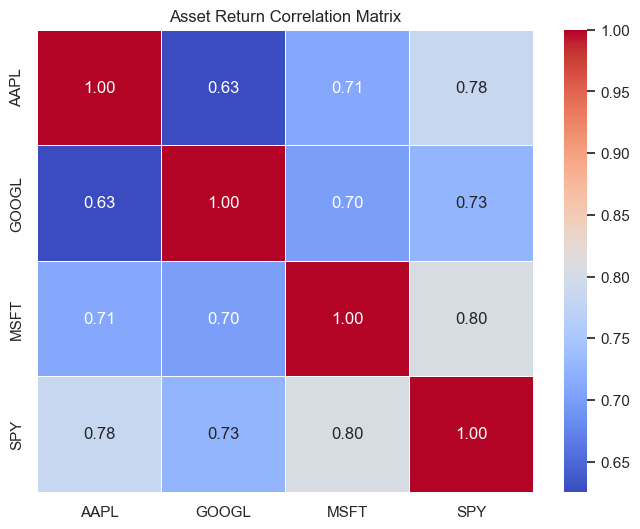

In [63]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap="coolwarm", 
            fmt=".2f",
            linewidths=0.5)

plt.title("Asset Return Correlation Matrix")
plt.show()


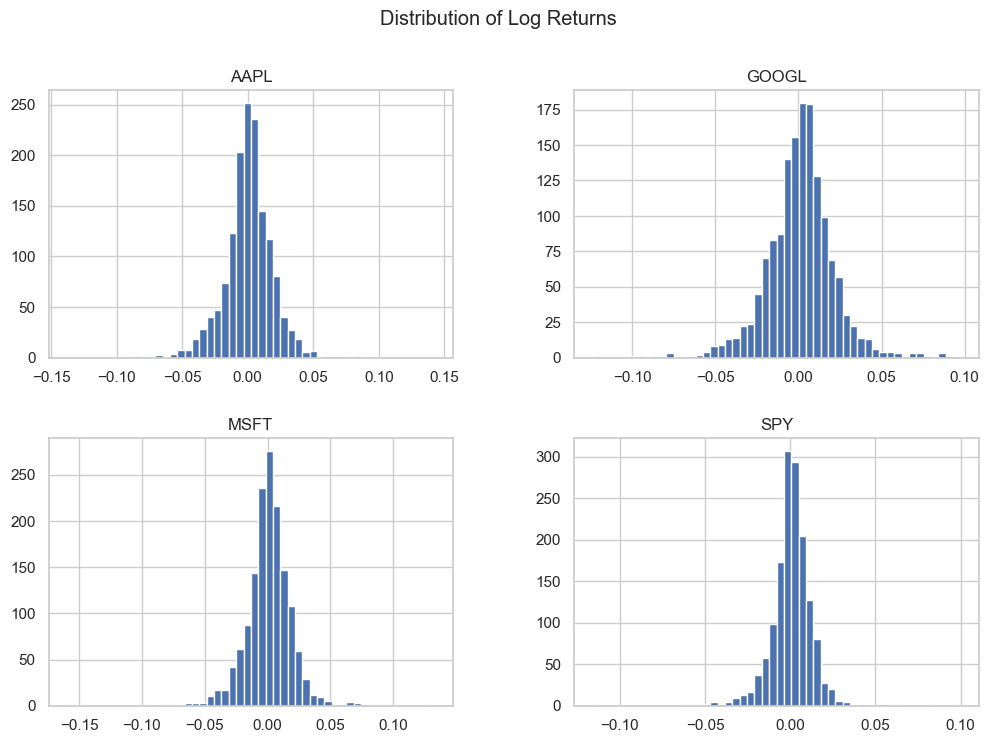

In [64]:
returns.hist(bins=50, figsize=(12,8))
plt.suptitle("Distribution of Log Returns")
plt.show()


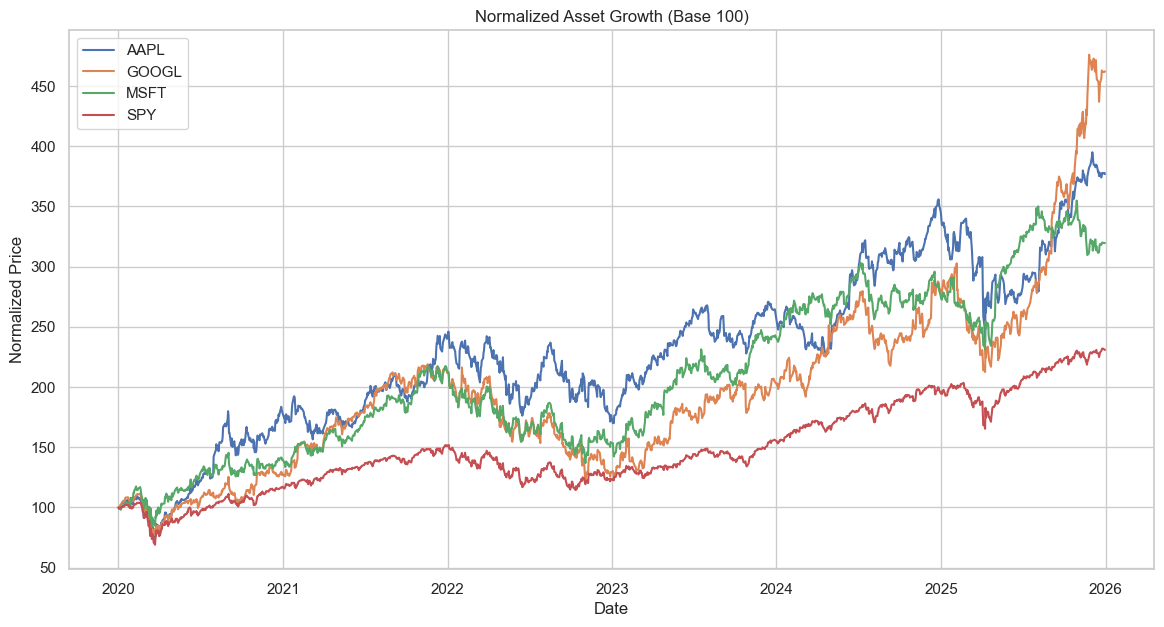

In [65]:
# Normalize prices to start at 100 for comparison
normalized_prices = (prices / prices.iloc[0]) * 100

plt.figure(figsize=(14, 7))
for asset in normalized_prices.columns:
    plt.plot(normalized_prices.index, normalized_prices[asset], label=asset)

plt.title("Normalized Asset Growth (Base 100)")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

# Mean–Variance Optimization (Monte Carlo)

In [66]:
# ============================================================
# 5. Mean–Variance Optimization (PHASE 2)
# ============================================================

import numpy as np

np.random.seed(42)

trading_days = 252
risk_free_rate = 0.02  # 2% annual risk-free rate

mu = annualized_mean
Sigma = annualized_cov

num_assets = len(mu)
num_portfolios = 10000


In [67]:
# Monte Carlo Simulation of Portfolios
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    
    # Random weights
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    weights_record.append(weights)
    
    # Portfolio return
    portfolio_return = np.dot(weights, mu)
    
    # Portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    
    # Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio


In [68]:
# Results to DataFrame
portfolio_results = pd.DataFrame(results.T, 
                                  columns=["Return", "Volatility", "Sharpe"])

weights_df = pd.DataFrame(weights_record, columns=mu.index)

portfolio_results = pd.concat([portfolio_results, weights_df], axis=1)

portfolio_results.head()


,Return,Volatility,Sharpe,AAPL,GOOGL,MSFT,SPY
0,0.208116,0.258234,0.728469,0.141022,0.357962,0.275610,0.225406
1,0.167509,0.222386,0.663299,0.126201,0.126181,0.046983,0.700635
2,0.197640,0.245363,0.723987,0.261391,0.307900,0.008951,0.421758
3,0.212899,0.274746,0.702101,0.590380,0.150594,0.128953,0.130073
4,0.210463,0.260581,0.730917,0.196011,0.338079,0.278284,0.187627


In [69]:
# Identify Optimal Portfolios
# Maximum Sharpe Ratio Portfolio
max_sharpe_port = portfolio_results.loc[portfolio_results["Sharpe"].idxmax()]

# Minimum Volatility Portfolio
min_vol_port = portfolio_results.loc[portfolio_results["Volatility"].idxmin()]

print("Maximum Sharpe Portfolio:")
display(max_sharpe_port)

print("Minimum Volatility Portfolio:")
display(min_vol_port)


Maximum Sharpe Portfolio:


Return        0.239230
Volatility    0.287753
Sharpe        0.761871
AAPL          0.332095
GOOGL         0.579002
MSFT          0.087703
SPY           0.001200
Name: 7629, dtype: float64

Minimum Volatility Portfolio:


Return        0.146484
Volatility    0.211063
Sharpe        0.599272
AAPL          0.029679
GOOGL         0.019757
MSFT          0.033395
SPY           0.917169
Name: 8637, dtype: float64

##  Efficient Frontier Visualization

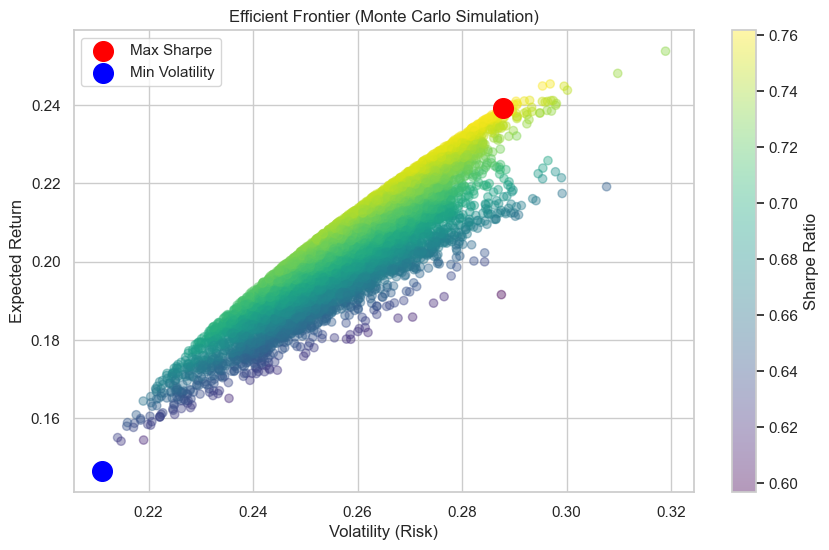

In [70]:
# Efficient Frontier
plt.figure(figsize=(10,6))

scatter = plt.scatter(portfolio_results["Volatility"],
                      portfolio_results["Return"],
                      c=portfolio_results["Sharpe"],
                      cmap="viridis",
                      alpha=0.4)

plt.colorbar(scatter, label="Sharpe Ratio")

# Highlight optimal portfolios
plt.scatter(max_sharpe_port["Volatility"], 
            max_sharpe_port["Return"], 
            color="red", 
            s=200, 
            label="Max Sharpe")

plt.scatter(min_vol_port["Volatility"], 
            min_vol_port["Return"], 
            color="blue", 
            s=200, 
            label="Min Volatility")

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier (Monte Carlo Simulation)")
plt.legend()
plt.show()


# Return Simulation Under Uncertainty


In [71]:
# Multivariate Normal Simulation
# ============================================================
# 6. Monte Carlo Simulation of Future Returns (PHASE 3)
# ============================================================

num_simulations = 10000

simulated_returns_normal = np.random.multivariate_normal(
    mean=mu,
    cov=Sigma,
    size=num_simulations
)

simulated_returns_normal = pd.DataFrame(
    simulated_returns_normal,
    columns=mu.index
)

simulated_returns_normal.head()


,AAPL,GOOGL,MSFT,SPY
0,0.335886,0.451350,0.369279,0.226612
1,0.320369,0.549853,0.440642,0.109605
2,0.771001,0.794181,0.676984,0.583934
3,0.015860,0.407413,0.520840,0.116514
4,0.321304,-0.060438,0.120929,-0.020474


In [72]:
# Empirical Bootstrapping (Distribution-Free)
simulated_returns_bootstrap = returns.sample(
    n=num_simulations,
    replace=True
).reset_index(drop=True)

simulated_returns_bootstrap.head()


,AAPL,GOOGL,MSFT,SPY
0,0.003851,0.015620,0.073486,0.007062
1,-0.003228,-0.001407,0.004848,-0.000441
2,-0.013662,0.017009,0.008773,0.026657
3,-0.005496,0.018482,0.008882,0.000406
4,0.015365,-0.003944,-0.026104,0.009570


In [73]:
#Compare Distribution of Portfolio Returns
# Use the Max Sharpe portfolio weights from Phase 2.
# Extract optimal weights
optimal_weights = max_sharpe_port[mu.index].values

# Compute portfolio returns under both simulations
portfolio_normal = simulated_returns_normal @ optimal_weights
portfolio_bootstrap = simulated_returns_bootstrap @ optimal_weights


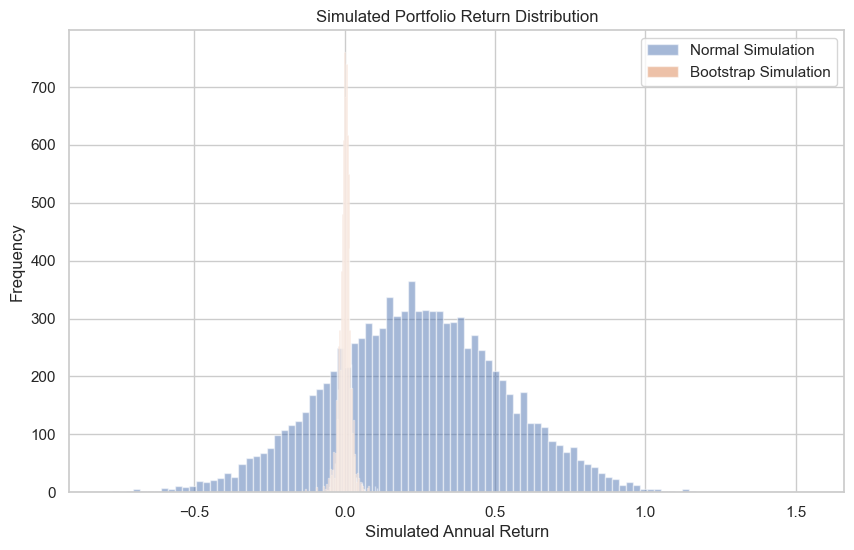

In [74]:
# Visual Comparison
plt.figure(figsize=(10,6))

plt.hist(portfolio_normal, bins=100, alpha=0.5, label="Normal Simulation")
plt.hist(portfolio_bootstrap, bins=100, alpha=0.5, label="Bootstrap Simulation")

plt.title("Simulated Portfolio Return Distribution")
plt.xlabel("Simulated Annual Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [75]:
# Risk Metrics Comparison
def compute_risk_metrics(portfolio_returns):
    mean = np.mean(portfolio_returns)
    std = np.std(portfolio_returns)
    var_95 = np.percentile(portfolio_returns, 5)
    cvar_95 = portfolio_returns[portfolio_returns <= var_95].mean()
    
    return {
        "Mean": mean,
        "Volatility": std,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95
    }

normal_metrics = compute_risk_metrics(portfolio_normal)
bootstrap_metrics = compute_risk_metrics(portfolio_bootstrap)

comparison = pd.DataFrame([normal_metrics, bootstrap_metrics],
                          index=["Normal Simulation", "Bootstrap Simulation"])

comparison


,Mean,Volatility,VaR (95%),CVaR (95%)
Normal Simulation,0.233469,0.288113,-0.241163,-0.364487
Bootstrap Simulation,0.000991,0.018027,-0.027631,-0.041420


### 5.1 Drawdown Curve

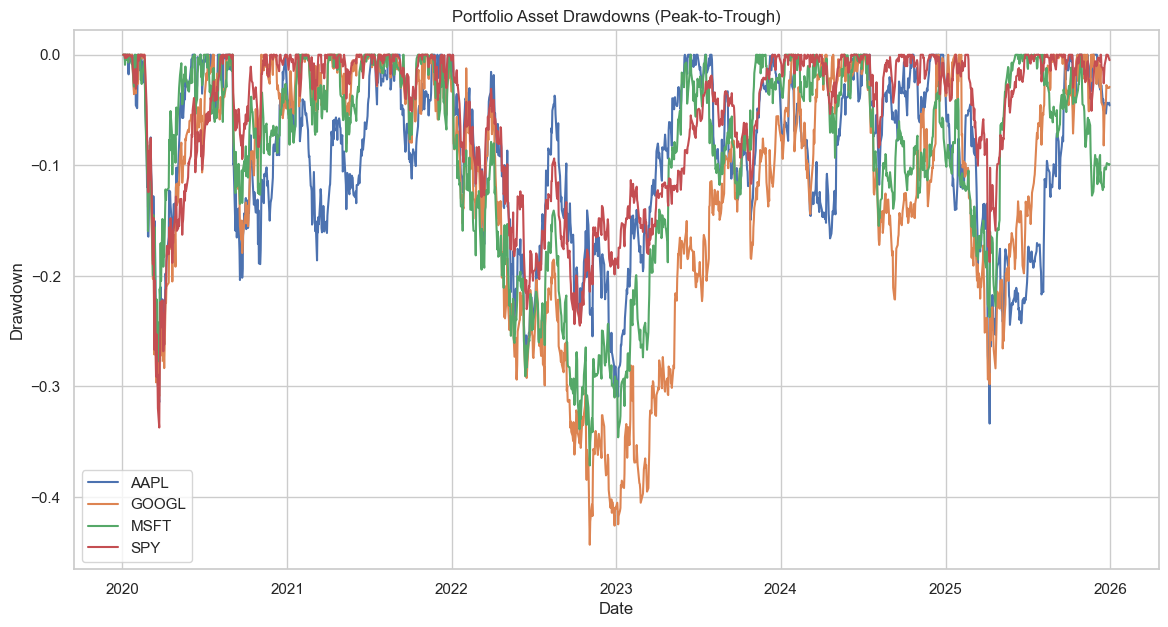

In [76]:
cumulative_returns = (1 + log_returns).cumprod()
peak = log_returns.cumsum().apply(np.exp).expanding(min_periods=1).max()
drawdown = (log_returns.cumsum().apply(np.exp) / peak) - 1

plt.figure(figsize=(14, 7))
for asset in drawdown.columns:
    plt.plot(drawdown.index, drawdown[asset], label=asset)

plt.title("Portfolio Asset Drawdowns (Peak-to-Trough)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.show()

## 6. Monte Carlo Simulation for Portfolio Optimization

In [77]:
num_portfolios = 10000
all_weights = np.zeros((num_portfolios, len(tickers)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for i in range(num_portfolios):
    # Weights
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights)
    all_weights[i, :] = weights
    
    # Expected Return
    ret_arr[i] = np.sum((log_returns.mean() * weights) * 252)
    
    # Expected Volatility
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

max_sharpe_idx = sharpe_arr.argmax()
print(f"Best Sharpe Ratio: {sharpe_arr[max_sharpe_idx]:.2f}")
print(f"Weights for Optimal Portfolio: {dict(zip(tickers, all_weights[max_sharpe_idx, :]))}")

Best Sharpe Ratio: 0.83
Weights for Optimal Portfolio: {'AAPL': np.float64(0.3739221973643097), 'MSFT': np.float64(0.5708824192135764), 'GOOGL': np.float64(0.035541978671917066), 'SPY': np.float64(0.01965340475019702)}
